In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('hh_ru_dataset.csv')

In [55]:
df[['initial_state', 'final_state']].value_counts()

initial_state  final_state
response       response       242739
               invitation     102976
invitation     invitation      80523
response       discard         72006
invitation     discard           846
discard        discard            76
dtype: int64

В целом смотрим только на следующие столбцы: final_state, work_experience_months, education_level, expected_salary, compensation_from, compensation_to в срезе profession

In [56]:

# отбрасываем дубликаты
# df = df[['profession', 'final_state', 'expected_salary', 'compensation_from', 'compensation_to'
#          , 'work_experience_months', 'education_level']]
df = df.drop_duplicates()
df = df[(~df.profession.isna())&(~df.expected_salary.isna())&(~df.education_level.isna())&(~df.final_state.isna())&(~df.compensation_from.isna()) & (~df.compensation_to.isna()) & (~df.work_experience_months.isna())]
df = df[(df.compensation_to != 0)&(df.expected_salary!=0)]

In [57]:
# compensation_from - убирать нули и выбросы?
df = df[df.work_experience_months <= (df.year_of_birth + 1 - 14)*12]

In [58]:
# отбрасывание статусов response-response, т.к. не знаем что с ними делать
df = df[df.final_state!='response']

Новые столбцы

In [59]:
df['final_state'] = df['final_state'].map(lambda x: int(x=='invitation'))

In [60]:

edu_dict = {
    'secondary' : 0,
    'special_secondary': 1,
    'unfinished_higher':2,
    'bachelor':3,
    'higher':3,
    'master':4,
    'candidate':4,
    'doctor':4
}
df['education_level'] = df['education_level'].map(lambda x: edu_dict[x])

In [61]:
management = ['Менеджер по продажам, менеджер по работе с клиентами', 'Бухгалтер', 'Менеджер по маркетингу, интернет-маркетолог',
             'Менеджер по персоналу', 'Менеджер по логистике, менеджер по ВЭД', 'Специалист по подбору персонала',
             'Менеджер по закупкам', 'Директор магазина, директор сети магазинов', 'Руководитель отдела продаж',
             'Офис-менеджер', 'Секретарь, помощник руководителя, ассистент', 'Руководитель проектов',
             'Финансовый менеджер', 'Администратор', 'Продавец-консультант, продавец-кассир', 
             'Менеджер по туризму', 'Координатор отдела продаж', 'Менеджер ресторана', 'Специалист по кадрам',
             'Менеджер/руководитель АХО']
design = ['Дизайнер, художник']
it = ['Программист, разработчик', 'Оператор ПК, оператор базы данных', 'Системный администратор',
     'SMM-менеджер, контент-менеджер', 'Тестировщик', 'Аналитик']
service = ['Официант, бармен, бариста', 'Специалист технической поддержки', 'Водитель', 'Охранник',
          'Курьер', 'Супервайзер', 'Кассир-операционист', 'Диспетчер', 'Торговый представитель', 
          'Упаковщик, комплектовщик', 'Повар, пекарь, кондитер', 'Кладовщик', 
          'Продавец-консультант, продавец-кассир', 'Начальник склада', 'Фитнес-тренер, инструктор тренажерного зала',
          'Товаровед', 'Оператор call-центра, специалист контактного центра', 'Уборщица, уборщик',
          'Разнорабочий', 'Мерчандайзер']
law = ['Делопроизводитель, архивариус', 'Юрисконсульт', 'Экономист', 'Юрист', 'Кредитный специалист']
engineering = ['Инженер-энергетик, инженер-электрик', 'Сварщик', 'Инженер-конструктор, инженер-проектировщик',
              'Слесарь, сантехник', 'Начальник производства', 'Начальник смены, мастер участка', 
              'Оператор производственной линии', 'Технолог', 'Машинист', 'Механик', 'Сервисный инженер, инженер-механик',
              'Инженер по охране труда и технике безопасности, инженер-эколог']
teacher = ['Учитель, преподаватель, педагог', 'Воспитатель, няня']
med = ['Психолог', 'Врач']
def f(x):
    if x in management:
        return "Менеджмент"
    if x in design:
        return "Дизайн"
    if x in it:
        return "IT"
    if x in service:
        return "Сфера услуг"
    if x in law:
        return "Право/Экономика"
    if x in engineering:
        return "Инженерия/Промышленность"
    if x in teacher:
        return "Образование"
    return "Медицина"
df['occupation'] = df.profession.map(f)

In [62]:
d = dict()
qs = dict()
compensation_qs = dict()
for i in df.profession.unique():
    temp = df[df.profession==i]
    t1 = temp.groupby('resume_id').expected_salary.mean()
    q1, q2 = t1.quantile(0.05), t1.quantile(0.95)
    if q1 < 1000:
        print(i)
    if q2 > 1000000:
        print(i, q2)
    qs[i] = (q1, q2)
    t2 = temp.groupby('vacancy_id').compensation_to.mean()
    q1, q2 = t2.quantile(0.05), t2.quantile(0.95)
    if q1 < 1000:
        print(i)
    if q2 > 1000000:
        print(i, q2)
    compensation_qs[i] = (q1, q2)
    
def app(x):
    q = qs[x['profession']]
    q1 = compensation_qs[x['profession']]
    a = (q[0] <= x['expected_salary']) and (x['expected_salary'] <= q[1])
    b = (q1[0] <= x['compensation_to']) and (x['compensation_to'] <= q1[1])
    return  a and b
df = df[df.apply(app, 1)]
    
    
for i in df.profession.unique():
    t = df[df.profession==i].groupby('vacancy_id')
    d[i] = ((t.compensation_to.mean() + t.compensation_from.mean())/2).median() #медиана средних зп
def temp(x):
    t = d[x['profession']]
    return (x['expected_salary'] - t) / t
df['delta_salary'] = df.apply(temp, 1)

In [63]:
df.to_csv('new_normal.csv')

In [64]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
import statsmodels.stats.tests.test_influence
import numpy as np

In [65]:
def show_cat(cat, print_sum=False):
    temp = df[df.profession.map(lambda x: x in cat)]
    x = temp[['delta_salary', 'education_level', 'work_experience_months']]
    x1 = sm.add_constant(x)
    y = temp['final_state']
    model_1 = sm.GLM(
        y,
        x1,
        family=families.Binomial(),
    ).fit()
    if print_sum:
        print(model_1.summary())
    ans = str(model_1.summary()).splitlines()[15][61:66]
    return float(ans)
    # print(model_1.normalized_cov_params)
    # return model_1.pvalues['delta_salary'], model_1.normalized_cov_params['delta_salary']

In [66]:
show_cat(['Врач'], True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:                  572
Model:                            GLM   Df Residuals:                      568
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.81
Date:                Wed, 20 Dec 2023   Deviance:                       647.62
Time:                        07:35:26   Pearson chi2:                     571.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.007547
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

0.147

In [67]:
def show_cat_1(temp, print_sum=False):
    x = temp[['delta_salary', 'education_level', 'work_experience_months']]
    x1 = sm.add_constant(x)
    y = temp['final_state']
    model_1 = sm.GLM(
        y,
        x1,
        family=families.Binomial(),
    ).fit()
    if print_sum:
        print(model_1.summary())
    ans = str(model_1.summary()).splitlines()[15][61:66]
    return float(ans)
    # print(model_1.normalized_cov_params)
    # return model_1.pvalues['delta_salary'], model_1.normalized_cov_params['delta_salary']
def show_cat_diff(row, print_sum=False):
    a = df[df[row] <= df[row].median()]
    b = df[df[row] > df[row].median()]
    return (show_cat_1(a, print_sum), show_cat_1(b, print_sum))

In [68]:
res = pd.DataFrame({}, columns=['profession', 'p-value', 'df_counts', 'ok'])
for i in df.occupation.unique():
    t = show_cat_1(df[df.occupation==i])
    if True:
        res=res.append({'profession':i, 'p-value':t, 'df_counts':(df.occupation==i).sum(),
                       'ok':"YES" if t<0.05 else "No"}, ignore_index=True)
res.columns = ['Сфера деятельности', 'p-значение', 'Количество наблюдений', 'Значимость отклонения']
res

/tmp/ipykernel_20677/1135646397.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t, 'df_counts':(df.occupation==i).sum(),
/tmp/ipykernel_20677/1135646397.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t, 'df_counts':(df.occupation==i).sum(),
/tmp/ipykernel_20677/1135646397.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t, 'df_counts':(df.occupation==i).sum(),
/tmp/ipykernel_20677/1135646397.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t, 'df_counts':(d

,Сфера деятельности,p-значение,Количество наблюдений,Значимость отклонения
0,Менеджмент,0.0,35750,YES
1,Дизайн,0.0,858,YES
2,IT,0.0,14708,YES
3,Сфера услуг,0.0,39321,YES
4,Право/Экономика,0.0,8291,YES
5,Инженерия/Промышленность,0.0,12226,YES
6,Образование,0.0,981,YES
7,Медицина,0.0,1141,YES


In [69]:
res = pd.DataFrame({}, columns=['profession', 'p-value', 'mean_salary', 'df_counts', 'ok'])
for i in df.profession.unique():
    t = show_cat([i])
    if True:
        res=res.append({'profession':i, 'p-value':t,
                   'mean_salary':d[i], 'df_counts':(df.profession==i).sum(),
                       'ok':"No" if (t>0.05) else "YES"}, ignore_index=True)
res.columns = ['Специальность', 'p-значение', 'Средняя зп для специальности', 'Количество наблюдений', 'Значимость отклонения']
res

/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t,
/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t,
/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t,
/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t,
/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t,
/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t,
/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t,
/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res=res.append({'profession':i, 'p-value':t,
/tmp/ipykernel_20677/185143353.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

,Специальность,p-значение,Средняя зп для специальности,Количество наблюдений,Значимость отклонения
0,"Менеджер по продажам, менеджер по работе с кли...",0.000,90000.0,9924,YES
1,"Дизайнер, художник",0.000,60000.0,858,YES
2,"Программист, разработчик",0.040,90000.0,1089,YES
3,Бухгалтер,0.000,58875.0,2183,YES
4,"Менеджер по маркетингу, интернет-маркетолог",0.253,72500.0,1232,No
...,...,...,...,...,...
63,Разнорабочий,0.473,64712.5,755,No
64,Кредитный специалист,0.000,60000.0,648,YES
65,Инженер по охране труда и технике безопасности...,0.025,72500.0,190,YES
66,Специалист по кадрам,0.000,57500.0,270,YES


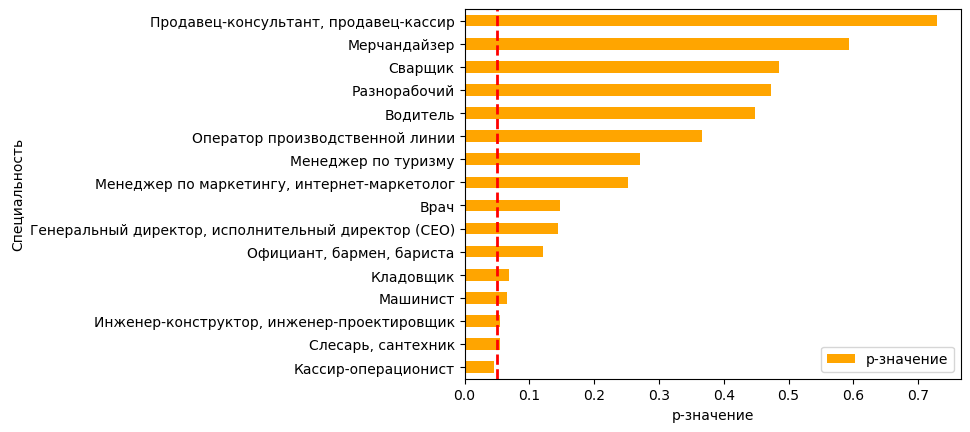

In [70]:
t = res[res['p-значение']>0.04]
t = t.sort_values('p-значение')
ax=t[['Специальность', 'p-значение']].plot(kind='barh', x='Специальность',ylabel='Специальность',
                                                                     xlabel = 'p-значение',color = 'orange')
ax.axvline(0.05, color='red', linestyle='dashed', linewidth=2)

plt.savefig('img/ochen_krutoi_graphik', bbox_inches='tight')

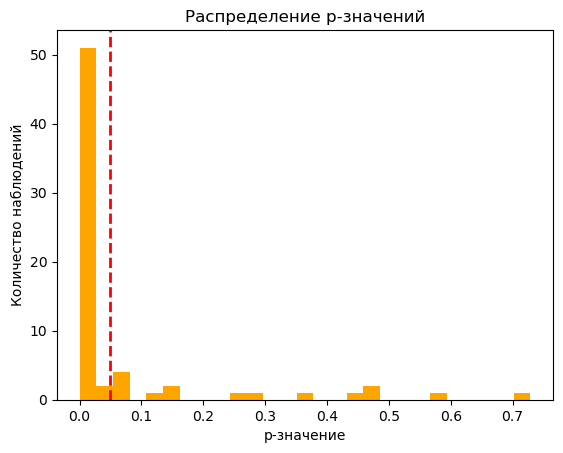

In [71]:
ax = res['p-значение'].plot.hist(bins=res['p-значение'].nunique(), color='orange')
plt.xlabel('p-значение')
plt.ylabel('Количество наблюдений')
plt.title('Распределение p-значений')
ax.axvline(0.05, color='red', linestyle='dashed', linewidth=2)
plt.savefig('img/p-value_rasp.png')

In [72]:
len(df), df.resume_id.nunique(), df.vacancy_id.nunique()

(113276, 70638, 73913)

In [73]:
show_cat(df.profession.unique(), True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:               113276
Model:                            GLM   Df Residuals:                   113272
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64937.
Date:                Wed, 20 Dec 2023   Deviance:                   1.2987e+05
Time:                        07:36:49   Pearson chi2:                 1.15e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04075
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

0.0

In [74]:
df['gender_num'] = df.gender.map(lambda x: float(x=='male'))

In [75]:
show_cat_diff('gender_num', True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:                62840
Model:                            GLM   Df Residuals:                    62836
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34371.
Date:                Wed, 20 Dec 2023   Deviance:                       68741.
Time:                        07:36:50   Pearson chi2:                 6.34e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03218
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

(0.0, 0.0)

In [76]:
show_cat_diff('year_of_birth', True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:                56679
Model:                            GLM   Df Residuals:                    56675
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33112.
Date:                Wed, 20 Dec 2023   Deviance:                       66225.
Time:                        07:37:03   Pearson chi2:                 5.71e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06684
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

(0.0, 0.0)

In [77]:
df['tc_date'] = pd.to_datetime(df.topic_creation_date)

In [78]:
show_cat_diff('tc_date', True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:                57911
Model:                            GLM   Df Residuals:                    57907
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33535.
Date:                Wed, 20 Dec 2023   Deviance:                       67071.
Time:                        07:37:10   Pearson chi2:                 5.86e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03436
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

(0.0, 0.0)

In [79]:
df.resume_region.unique() # luchshe po okrugam, no eto poposzhe

array(['Москва', 'Архангельская область', 'Ямало-Ненецкий АО',
       'Московская область', 'Псковская область', 'Костромская область',
       'Республика Карелия', 'Нижегородская область', 'Тюменская область',
       'Ивановская область', 'Краснодарский край', 'Красноярский край',
       'Санкт-Петербург', 'Новосибирская область', 'Приморский край',
       'Республика Башкортостан', 'Калужская область',
       'Челябинская область', 'Ярославская область', 'Орловская область',
       'Свердловская область', 'Республика Татарстан', 'Пермский край',
       'Ростовская область', 'Ханты-Мансийский АО - Югра',
       'Саратовская область', 'Владимирская область', 'Донецкая область',
       'Пензенская область', 'Ставропольский край', 'Самарская область',
       'Белгородская область', 'Воронежская область', 'Хабаровский край',
       'Астраханская область', 'Липецкая область', 'Иркутская область',
       'Республика Крым', 'Республика Марий Эл', 'Ленинградская область',
       'Республика С

In [80]:
df.relocation_status.isna().sum()

0

In [81]:
rs_cat = {
    'not_ready':0.0,
    'desirable':0.5,
    'possible':1.0
}
df['rs_cat'] = df.relocation_status.map(lambda x: rs_cat[x])

In [82]:
show_cat_diff('rs_cat', True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:                86805
Model:                            GLM   Df Residuals:                    86801
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48368.
Date:                Wed, 20 Dec 2023   Deviance:                       96735.
Time:                        07:37:19   Pearson chi2:                 8.80e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03326
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

(0.0, 0.0)

In [83]:
df.business_trip_readiness.unique()

array(['ready', 'never', 'sometimes'], dtype=object)

In [84]:
btr_cat = {
    'never':0.0,
    'sometimes':0.5,
    'ready':1.0
}
df['btr_cat'] = df.business_trip_readiness.map(lambda x: btr_cat[x])

In [85]:
show_cat_diff('btr_cat', True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:                59267
Model:                            GLM   Df Residuals:                    59263
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31926.
Date:                Wed, 20 Dec 2023   Deviance:                       63851.
Time:                        07:37:21   Pearson chi2:                 5.99e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01830
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

(0.0, 0.0)

In [67]:
# graphik raboti nado smotret' esche i tam i tam y employment_type

In [86]:
df['work_schedule.1'].value_counts()

full_day       59750
remote         25766
shift          16301
flexible        9567
flyInFlyOut     1892
Name: work_schedule.1, dtype: int64

In [87]:
schedule_cats = {
    'full_day':0,
    'remote':1,
    'shift':0,
    'flexible':1,
    'flyInFlyOut': 0.5
}
df['ws_cat'] = df['work_schedule'].map(lambda x: schedule_cats.get(x, 0))
df['ws1_cat'] = df['work_schedule.1'].map(lambda x: schedule_cats.get(x, 0))

In [88]:
df.ws1_cat.median()

0.0

In [89]:
show_cat_diff('ws_cat',True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:                90361
Model:                            GLM   Df Residuals:                    90357
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51285.
Date:                Wed, 20 Dec 2023   Deviance:                   1.0257e+05
Time:                        07:37:34   Pearson chi2:                 9.17e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04194
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

(0.0, 0.0)

In [91]:
show_cat_diff('ws1_cat', True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            final_state   No. Observations:                76051
Model:                            GLM   Df Residuals:                    76047
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44142.
Date:                Wed, 20 Dec 2023   Deviance:                       88284.
Time:                        07:37:51   Pearson chi2:                 7.71e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05520
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

(0.0, 0.0)

In [92]:
df.vacancy_employment_type.value_counts()

full         93134
part         19005
probation      869
project        268
Name: vacancy_employment_type, dtype: int64

In [93]:
show_cat_1(df[df.vacancy_employment_type=='part'])

0.106

In [94]:
show_cat_1(df[df.resume_employment_type=='part'])

0.0